# Learning to play Pong with Deep Reinforcement Learning

![PongUrl](https://pygame-learning-environment.readthedocs.io/en/latest/_images/pong.gif "pong")

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Setup

### Dependencies and constants

In [2]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # No cuda available on personal laptop
os.environ["CUDA_VISIBLE_DEVICES"] = ""

os.putenv('SDL_VIDEODRIVER', 'fbcon') # settings for pygame display
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
from ple import PLE
from ple.games.pong import Pong
import pygame

Using TensorFlow backend.


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


### Game setup

Here we load the Pong Reinforcement Learning environment from PLE. We limit each game (episode) to 7 points so that we can train faster.

We also define a preprocessing function `process_state` that normalizes the state values to have maximum norms close to 1. Feature normalization has been seen to generally help neural networks learn faster, and is common practice in deep reinforcement learning.

In [4]:
NORMALIZE_FACTORS = np.array([48, 50, 48, 64, 48, 50, 50])

def process_state(state):
    state = np.array(list(state.values()))
    state /= NORMALIZE_FACTORS
    
    return state

In [5]:
# Setting up the game environment, refer to the PLE docs if you want to know the details
game = Pong(MAX_SCORE=7)
game_env = PLE(game, fps=30, display_screen=False, state_preprocessor=process_state, reward_values = {"win": 0, "loss": 0})

### Utilities

We include a function that lets you visualize an "episode" (i.e. a series of observations resulting from the actions that the agent took in the environment).

As well, the `Results` class (a wrapper around a python dictionary) to store, save, load and plot your results. You can save your results to disk with results.save('filename') and reload them with Results(filename='filename'). Use results.pop(experiment_name) to delete an old experiment.

In [6]:
def render(episode):
    
    fig = plt.figure()
    img = plt.imshow(np.transpose(episode[0],[1,0,2]))
    plt.axis('off')

    def animate(i):
        img.set_data(np.transpose(episode[i],[1,0,2]))
        return img,

    anim = FuncAnimation(fig, animate, frames=len(episode), interval=24, blit=True)
    html = HTML(anim.to_jshtml())
    
    plt.close(fig)
    !rm None0000000.png
    
    return html


class Results(dict):
    
    def __init__(self, *args, **kwargs):
        if 'filename' in kwargs:
            data = np.load(kwargs['filename'])
            super(Results, self).__init__(data)
        else:
            super(Results, self).__init__(*args, **kwargs)
        self.new_key = None
        self.plot_keys = None
        self.ylim = None
        
    def __setitem__(self, key, value):
        super().__setitem__(key, value)
        self.new_key = key

    def plot(self, window):
        clear_output(wait=True)
        for key in self:
            #Ensure latest results are plotted on top
            if self.plot_keys is not None and key not in self.plot_keys:
                continue
            elif key == self.new_key:
                continue
            self.plot_smooth(key, window)
        if self.new_key is not None:
            self.plot_smooth(self.new_key, window)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc='lower right')
        if self.ylim is not None:
            plt.ylim(self.ylim)
        plt.show()
        
    def plot_smooth(self, key, window):
        if len(self[key]) == 0:
            plt.plot([], [], label=key)
            return None
        y = np.convolve(self[key], np.ones((window,))/window, mode='valid')
        x = np.linspace(window/2, len(self[key]) - window/2, len(y))
        plt.plot(x, y, label=key)
        
    def save(self, filename='results'):
        np.savez(filename, **self)

### Test runs

To get an idea of how the environment works, we'll plot an episode resulting from random actions at each point in time.

In [7]:
# 119 / 115 / None
def run_fixed_episode(env, policy):
    frames = []
    env.reset_game()
    done = False
    while not done:
        observation = env.getGameState()
        
        action = policy(env, observation)
        frames.append(env.getScreenRGB())
        reward = env.act(action)
        done = env.game_over()
    return frames
    
def random_policy(env,observation):

    return random.sample(env.getActionSet(), 1)[0]

We also define a function to run an episode with the policies that you will be training

In [9]:
def run_fixed_episode_learned(env, policy):
    frames = []
    env.reset_game()
    done = False
    while not done:
        observation = env.getGameState()
        action_idx = policy.decide(observation)
        action = env.getActionSet()[action_idx]
        frames.append(env.getScreenRGB())
        reward = env.act(action)
        done = env.game_over()
    
    return frames

## Experiment Loop

This is the method we will call to setup an experiment. Reinforcement learning usually operates on an Observe-Decide-Act cycle, as you can see below.

You don't need to add anything here; you will be working directly on the RL agent.

In [10]:
num_episodes = 5000

def run_experiment(experiment_name, env, num_episodes, reward_shaping=False, 
                   policy_learning_rate=0.001, value_learning_rate = 0.001, 
                   baseline=None, fileNamePolicy=None, fileNameValue=None, verbose=False, stopping_criterion=20):

    env.init()
    discount_factor = 0.99
    
    #Initiate the learning agent
    agent = RLAgent(n_obs = env.getGameStateDims()[0], policy_learning_rate = policy_learning_rate, value_learning_rate = value_learning_rate, 
                    discount=discount_factor, baseline=baseline, fileNamePolicy=fileNamePolicy, fileNameValue=fileNameValue)

    rewards = []
    all_episode_frames = []
    
    points_won = 0
    games_won = 0
    win_streak = 0
    
    for episode in range(1, num_episodes+1):
    
        #Update results plot and occasionally store an episode movie
        episode_frames = None
        if episode % 10 == 0:
            results[experiment_name] = np.array(rewards)
            results.plot(10)
            if verbose:
                print("Number of games won: " + str(int(games_won)))
                print("Number of points won: " + str(int(points_won)))
        if episode % 500 == 0:
            episode_frames = []
            
        #Reset the environment for a new episode
        env.reset_game()
            
        observation = env.getGameState()
        
        player_points = 0
        opponent_points = 0
        
        episode_steps = 0
        episode_reward = 0

        while True:
        
            if episode_frames is not None:
                episode_frames.append(env.getScreenRGB())

            # 1. Decide on an action based on the observations
            action_idx = agent.decide(observation)
            # convert action index into commands expected by the game environment
            action = game_env.getActionSet()[action_idx]
            # 2. Take action in the environment
            raw_reward = env.act(action)
            next_observation = env.getGameState()
            
            if raw_reward > 0:
                points_won += raw_reward
                player_points += raw_reward
            elif raw_reward < 0:
                opponent_points += np.abs(raw_reward)
            
            episode_steps += 1
            
            # 3. Reward shaping            
            if reward_shaping:
                auxiliary_reward = reward_design(observation)
                reward = raw_reward + auxiliary_reward
            else:
                reward = raw_reward
    
            episode_reward += reward

            # 4. Store the information returned from the environment for training
            agent.observe(observation, action_idx, reward)

            # 5. When we reach a terminal state ("done"), use the observed episode to train the network
            done = env.game_over() # Check if game is over
            if done:
                rewards.append(episode_reward)
                agent.train()
                
                # Some diagnostics
                if verbose:
                    print("Game score: " + str(int(player_points)) + "-" + str(int(opponent_points)) + " over "
                          + str(episode_steps) + " frames")
                
                # Calculating the win streak (number of consecutive games won)
                if player_points > opponent_points:
                    print("Won a game at episode " + str(episode) + "!")
                    games_won += 1
                    win_streak += 1
                else:
                    win_streak = 0
                    
                if episode_frames is not None:
                    all_episode_frames.append(episode_frames)                    
                
                break

            # Reset for next step
            observation = next_observation
        
        # Stop if you won enough consecutive games
        if win_streak == stopping_criterion:
            break
            
    return all_episode_frames, agent

In [11]:
def reward_design(observation):    
    ball_vel = observation[5]
    
    auxiliary_reward = 0
    if ball_vel>0:
        auxiliary_reward = 1e-3
    return auxiliary_reward

## The Agent

Here we give the outline of a python class that will represent the reinforcement learning agent (along with its decision-making network). 




In [12]:
class RLAgent(object):
    
    def __init__(self, n_obs, policy_learning_rate, value_learning_rate, 
                 discount, baseline=None, fileNamePolicy=None, fileNameValue=None):

        #We need the state and action dimensions to build the network
        self.n_obs = n_obs  
        self.n_act = 1
        
        self.gamma = discount
        
        self.use_baseline = baseline is not None
        self.use_adaptive_baseline = baseline == 'adaptive'

        #Fill in the rest of the agent parameters to use in the methods below
        
        self.policy_learning_rate=policy_learning_rate
        # TODO
        if self.use_adaptive_baseline is not None : 
            
            self.model, self.model_adaptatif = self._build_network()
        else: 
            self.model = self._build_network()
        #These lists stores the observations for this episode
        self.episode_observations, self.episode_actions, self.episode_rewards = [], [], []
        #Build the keras network
        self.fileNamePolicy = fileNamePolicy
        self.fileNameValue = fileNameValue

        
    def observe(self, state, action, reward):
        """ This function takes the observations the agent received from the environment and stores them
            in the lists above. """
        self.episode_observations.append(np.array(state)) # list of 7 values 
        self.episode_actions.append(action)# 0 / 1 / index of action
        self.episode_rewards.append(reward) # value 
            
    def _get_returns(self):
        """ This function should process self.episode_rewards and return the discounted episode returns
            at each step in the episode, then optionally apply a baseline. Hint: work backwards."""
        
        moving_averages =[]
        returns = np.zeros(len(self.episode_rewards))
        r = 0
        ## Browse the inverted episode rewards to compute the cumulative reward
        for i in reversed(range(len(self.episode_rewards))): ##Formula 
            if self.episode_rewards[i] != 0: r = 0
            r = r * self.gamma + self.episode_rewards[i]
            returns[i] = r
        
        ## Moving average
        if self.use_baseline is not None :
            N = 50 
            for i in range(len(returns)):
                window = returns[i : i + N]
                window_average = np.mean(window)
                moving_averages.append(window_average)
            returns = np.asarray(moving_averages)
            
        return returns
    
    def _build_network(self):
        """ This function should build the network that can then be called by decide and train. 
            The network takes observations as inputs and has a policy distribution as output."""
        
        model = Sequential()
        model.add(Dense(32, input_dim=7, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(2,activation='softmax'))
    
        ##Value_network
        keras.optimizers.Adam(learning_rate=0.01)#policy_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='binary_crossentropy', optimizer='adam')
        
        if (self.use_adaptive_baseline is not None):
            model_adaptatif = Sequential()
            model_adaptatif.add(Dense(32, input_dim=7, activation='relu'))
            model_adaptatif.add(Dense(32, activation='relu'))
            model_adaptatif.add(Dense(32, activation='relu'))
            model_adaptatif.add(Dense(1))
            model_adaptatif.compile(loss='mean_squared_error',optimizer='adam',metrics=['mae', 'mse'])
            return model , model_adaptatif
        else: 
            return model
    
    def decide(self, state):
        """ This function feeds the observed state to the network, which returns a distribution
            over possible actions. Sample an action from the distribution and return it."""
        
        # Sample over a Bernoulli Distribution 
        policy = self.model.predict(np.array([state]),batch_size=1).flatten()##p must be 1D array
        
        return np.random.choice(2,1,p=policy)[0]##actions,p=policy
        
    def train_target(self,rewards): 
        
        
        ## One hot encoding of the actions to take with respect to the expected reward 
        ## e.g : If action index 1 and reward doesn't penalize, action is kept
        ## This function creates a train target for training over action choice
        returns = self._get_returns()
        target = np.zeros((returns.shape[0],2))
        
        for i, (action_idx, reward) in enumerate(zip(self.episode_actions,self.episode_rewards)):
            
            state = np.zeros((1,2))
            state  = [0 , 1] if (action_idx == 1 and reward !=-1 or\
                                action_idx == 0 and reward ==-1) else [1, 0] 
            target[i,:] = state
                                 
        return target

    def train(self):
        """ When this function is called, the accumulated observations, actions and discounted rewards from the
            current episode should be fed into the network and used for training. Use the _get_returns function 
            to first turn the episode rewards into discounted returns. """
        discounted_rewards = self._get_returns()
        #standardize
        discounted_rewards -= np.mean(discounted_rewards)
        discounted_rewards /= np.std(discounted_rewards)
        train_target = self.train_target(discounted_rewards)

        if self.use_adaptive_baseline is not None : 
                
                print('\n# Evaluate on test data')
                results = self.model_adaptatif.train_on_batch(np.array(self.episode_observations),discounted_rewards)
                print('mae loss, mse :', results)
                baselines = self.model_adaptatif.predict(np.array(self.episode_observations))
                self.model.train_on_batch(np.array(self.episode_observations),train_target,sample_weight=(discounted_rewards-np.squeeze(baselines)))
        else:
                self.model.train_on_batch(np.array(self.episode_observations),train_target,sample_weight=discounted_rewards)
    
        #empty the episode's data
        self.episode_observations  =  []
        self.episode_actions = []
        self.episode_rewards = []


In [13]:
results= Results()

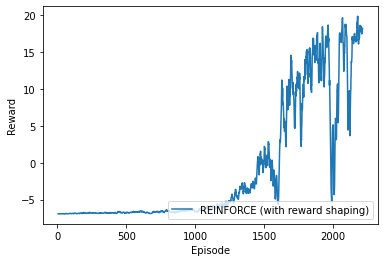

Number of games won: 301
Number of points won: 3258
Game score: 7-3 over 29291 frames
Won a game at episode 2220!


In [38]:
# Basic RL with shaping 
results = Results()
policy_learning_rate = 1e-2
_, basic_reinforce_policy = run_experiment("REINFORCE (with reward shaping)", game_env, num_episodes, reward_shaping=True,
                                           policy_learning_rate=policy_learning_rate, stopping_criterion=30,verbose= True)

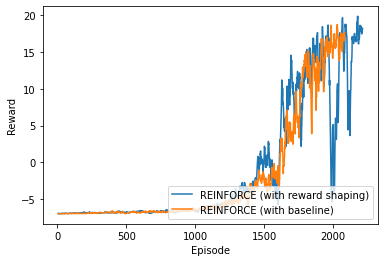

Number of games won: 231
Number of points won: 2513
Game score: 7-4 over 29823 frames
Won a game at episode 2090!
Game score: 7-4 over 18128 frames
Won a game at episode 2091!
Game score: 7-5 over 27547 frames
Won a game at episode 2092!
Game score: 7-0 over 18923 frames
Won a game at episode 2093!
Game score: 7-2 over 16781 frames
Won a game at episode 2094!
Game score: 7-5 over 25452 frames
Won a game at episode 2095!


In [40]:
#Baseline newtorks with reward shaping                                            
_, baseline_reinforce_policy = run_experiment("REINFORCE (with baseline)", game_env, num_episodes, reward_shaping=True,
                                              policy_learning_rate=policy_learning_rate, stopping_criterion=30,
                                              baseline='simple',verbose = True)

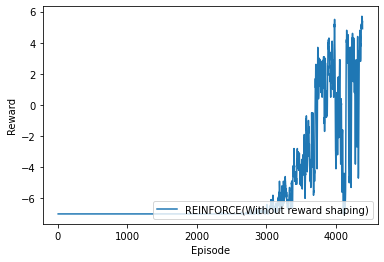

Number of games won: 446
Number of points won: 5080
Game score: 7-1 over 25760 frames
Won a game at episode 4390!


In [42]:
#basic network without reward shaping 
results = Results()
policy_learning_rate = 1e-2
_, basic_reinforce_policy_without = run_experiment("REINFORCE(Without reward shaping)", game_env, num_episodes, reward_shaping=False,policy_learning_rate=policy_learning_rate, stopping_criterion=30,verbose=True)

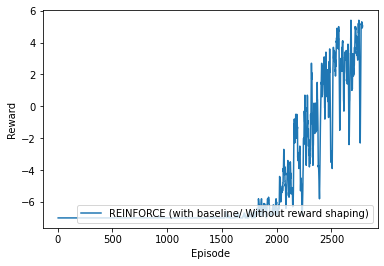

Number of games won: 368
Number of points won: 3810

# Evaluate on test data
mae loss, mse : [0.5043156, 0.3272135, 0.5043156]
Game score: 7-1 over 18985 frames
Won a game at episode 2790!

# Evaluate on test data
mae loss, mse : [0.41863388, 0.31420586, 0.41863388]
Game score: 7-1 over 17335 frames
Won a game at episode 2791!

# Evaluate on test data
mae loss, mse : [0.6540226, 0.27770683, 0.6540226]
Game score: 7-2 over 32820 frames
Won a game at episode 2792!

# Evaluate on test data
mae loss, mse : [0.74243104, 0.36676154, 0.74243104]
Game score: 7-3 over 21999 frames
Won a game at episode 2793!

# Evaluate on test data
mae loss, mse : [0.7923922, 0.3879511, 0.7923922]
Game score: 7-6 over 40222 frames
Won a game at episode 2794!

# Evaluate on test data
mae loss, mse : [0.6943979, 0.32137352, 0.6943979]
Game score: 7-4 over 40690 frames
Won a game at episode 2795!

# Evaluate on test data
mae loss, mse : [0.64298767, 0.36497915, 0.64298767]
Game score: 7-1 over 17708 frames
Won a 

In [14]:
#Simple baseline without reward shaping 
results = Results()
policy_learning_rate = 1e-2
_, baseline_reinforce_policy = run_experiment("REINFORCE (with baseline/ Without reward shaping)", game_env, num_episodes, reward_shaping=False,
                                              policy_learning_rate=policy_learning_rate, stopping_criterion=30,
                                              baseline='simple',verbose = True)

In [47]:
# You can save intermediate results to avoid rerunning experiments
results.save('results_exercise_1')

# You can also save your learned networks (you will have to adapt this to your naming of the network modules)
basic_reinforce_policy.model.save('exercise_1_basic_reinforce_policy_net_with_shaping.h5')
baseline_reinforce_policy.model.save('exercise_1_baseline_reinforce_policy_net.h5')
basic_reinforce_policy_without.model.save('exercise_1_basic_reinforce_policy_net_without_shaping.h5')

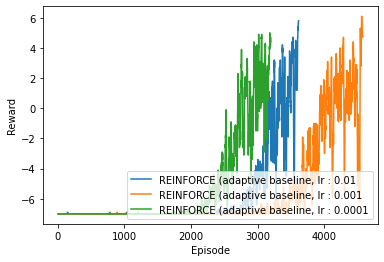

Number of games won: 330
Number of points won: 4046

# Evaluate on test data
mae loss, mse : [0.5443155, 0.40348864, 0.5443155]
Game score: 7-0 over 14956 frames
Won a game at episode 3200!

# Evaluate on test data
mae loss, mse : [0.48897344, 0.30241573, 0.48897344]
Game score: 7-0 over 15138 frames
Won a game at episode 3201!

# Evaluate on test data
mae loss, mse : [0.42767897, 0.31132886, 0.42767897]
Game score: 7-0 over 14450 frames
Won a game at episode 3202!

# Evaluate on test data
mae loss, mse : [0.53704554, 0.23917578, 0.53704554]
Game score: 7-1 over 21915 frames
Won a game at episode 3203!

# Evaluate on test data
mae loss, mse : [0.6583783, 0.34602135, 0.6583783]
Game score: 7-3 over 25354 frames
Won a game at episode 3204!

# Evaluate on test data
mae loss, mse : [0.6059324, 0.26920792, 0.6059324]
Game score: 7-2 over 25186 frames
Won a game at episode 3205!

# Evaluate on test data
mae loss, mse : [0.5807338, 0.2450741, 0.5807338]
Game score: 7-1 over 33517 frames
Won a

In [19]:
# Learning rate testing adaptative baseline networks
results = Results()

policy_learning_rate = 1e-2
value_learning_rate = [1e-2,1e-3,1e-4]
models = []

for lr in value_learning_rate:

    _, adaptive_policy = run_experiment("REINFORCE (adaptive baseline, lr : " + str(lr), game_env, num_episodes, reward_shaping=False,
                                        policy_learning_rate=policy_learning_rate, 
                                        value_learning_rate=lr, stopping_criterion=30,
                                        baseline='adaptive', verbose=True)
    models.append(adaptive_policy)

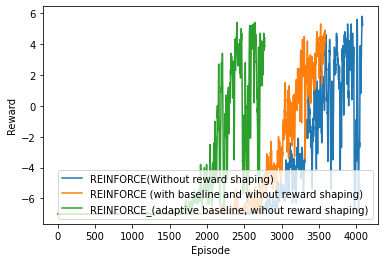

Number of games won: 399
Number of points won: 4128

# Evaluate on test data
mae loss, mse : [0.5931836, 0.24415465, 0.5931836]
Game score: 7-1 over 22645 frames
Won a game at episode 2780!

# Evaluate on test data
mae loss, mse : [0.508912, 0.36343083, 0.508912]
Game score: 7-0 over 17933 frames
Won a game at episode 2781!

# Evaluate on test data
mae loss, mse : [0.53245497, 0.3182291, 0.53245497]
Game score: 7-0 over 18472 frames
Won a game at episode 2782!

# Evaluate on test data
mae loss, mse : [0.59135675, 0.39209104, 0.59135675]
Game score: 7-0 over 11802 frames
Won a game at episode 2783!

# Evaluate on test data
mae loss, mse : [0.41584483, 0.23522043, 0.41584483]
Game score: 7-1 over 18673 frames
Won a game at episode 2784!

# Evaluate on test data
mae loss, mse : [0.5092948, 0.27727395, 0.5092948]
Game score: 7-0 over 19625 frames
Won a game at episode 2785!


In [20]:
#  best results : without baseline, with simple baseline, with adaptive baseline
results = Results()
policy_learning_rate = 1e-2
_, basic_reinforce_policy_without = run_experiment("REINFORCE(Without reward shaping)", game_env, num_episodes, reward_shaping=False,policy_learning_rate=policy_learning_rate, stopping_criterion=30,verbose=True)
_, baseline_reinforce_policy = run_experiment("REINFORCE (with baseline and wihout reward shaping)", game_env, num_episodes, reward_shaping=False,
                                              policy_learning_rate=policy_learning_rate, stopping_criterion=30,
                                              baseline='simple',verbose = True)
_, adaptive_policy = run_experiment("REINFORCE_(adaptive baseline, wihout reward shaping)", game_env, num_episodes, reward_shaping=False,
                                        policy_learning_rate=policy_learning_rate, 
                                        value_learning_rate=1e-4, stopping_criterion=30,
                                        baseline='adaptive', verbose=True)

In [17]:
# You can save intermediate results to avoid rerunning experiments
results.save('results_exercise_2_comparative.npz')

adaptive_policy.model.save('model_adaptative_no_shaping.h5')
adaptive_policy.model_adaptatif.save('model_adaptatif_parameters.h5')

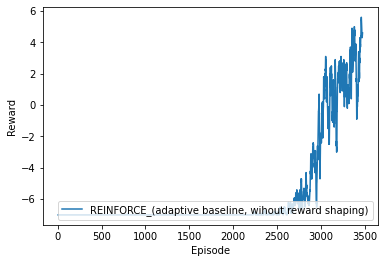

Number of games won: 333
Number of points won: 3617

# Evaluate on test data
mae loss, mse : [0.61092764, 0.33364066, 0.61092764]
Game score: 7-5 over 27659 frames
Won a game at episode 3480!

# Evaluate on test data
mae loss, mse : [0.7041963, 0.36293143, 0.7041963]
Game score: 7-0 over 26376 frames
Won a game at episode 3481!

# Evaluate on test data
mae loss, mse : [0.5827895, 0.30441162, 0.5827895]
Game score: 7-5 over 29881 frames
Won a game at episode 3482!


In [14]:
#Best adaptative baseline network for graph generation
results = Results()
policy_learning_rate = 1e-2 
_, adaptive_policy = run_experiment("REINFORCE_(adaptive baseline, wihout reward shaping)", game_env, num_episodes, reward_shaping=False,
                                        policy_learning_rate=policy_learning_rate, 
                                        value_learning_rate=1e-4, stopping_criterion=30,
                                        baseline='adaptive', verbose=True)

In [ ]:
results.save('results_exercise_2')
adaptive_policy.policy_net.save('exercise_2_policy_net.h5')
adaptive_policy.value_net.save('exercise_2_value_net.h5')

In [19]:
model = load_model('/Users/kamilseghrouchni/MEGAsync/EPFL/MA2/ANN/CS456RL/models/model_adaptatif_parameters.h5')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
None


In [20]:

from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.axes3d import get_test_data
from mpl_toolkits.mplot3d import Axes3D 



In [34]:
def plot_3d_surface(ax,x_axis,y_axis,z_axis,title,vmin,vmax) : 
    X =x_axis
    Y = y_axis
    Z =z_axis.reshape(X.shape[0])
    cmhot = plt.get_cmap("hot")
    # Plot the surface.
    vmin = np.min(Z)
    vmax = np.max(Z)
    surf = ax.scatter(X, Y, Z,c=Z , cmap=cm.coolwarm,vmin=vmin, vmax=vmax)
    # Customize the z axis.
    ax.set_zlim(-1,1)
    ax.zaxis.set_major_locator(LinearLocator(3))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_zlabel('Value fonction')
    ax.set_title(title)
    ## Add a color bar which maps values to colors.
    
    fig.colorbar(surf, shrink=0.5, aspect=3)


    ax.zaxis.set_major_locator(LinearLocator(3))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    return ax


def plot_3d (ax,x_axis,y_axis,z_axis,vmin,vmax): 
        # Make data.
    X = x_axis
    Y = y_axis
    Z =z_axis.reshape(X.shape[0])
    cmhot = plt.get_cmap("hot")
    # Plot the surface.
    surf = ax.scatter(X, Y, Z,c=Z , cmap=cm.coolwarm,vmin=vmin, vmax=vmax,)
    # Customize the z axis.
    ax.set_zlim(np.min(Z),np.max(Z))
    ax.zaxis.set_major_locator(LinearLocator(3))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_zlabel('Value fonction')
    fig.colorbar(surf, shrink=0.5, aspect=3)



    return ax

def genrate_random (N, xy_min, xy_max): 
    n = N
    xy_min = xy_min
    xy_max = xy_max
    data = np.random.uniform(low=xy_min, high=xy_max, size=(n,2))
    
    return data    

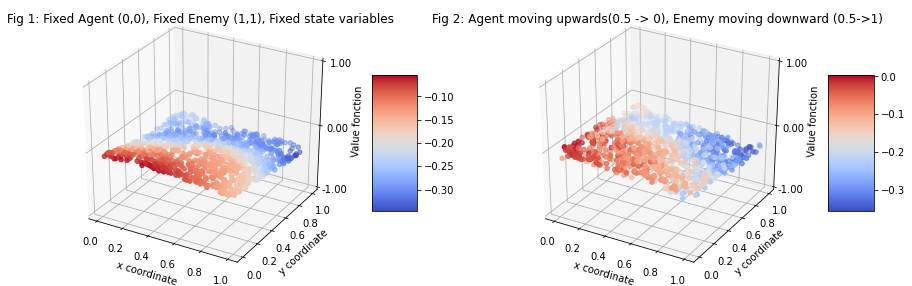

In [35]:



#===============
#  First subplot
#===============

data = genrate_random(1000,[0,0],[1,1])
means =np.zeros((1000,7))
means[:,3], means[:,4] = data[0:1000,0], data[0:1000,1]
means[:,0] =  np.zeros((1000))
means[:,2] =  np.ones((1000))

fig = plt.figure(figsize=(15,5))

Z = model.predict(means)
vmin = Z.min()
vmax = Z.max()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d_surface(ax1,means[:,3],means[:,4],model.predict(means),'Fig 1: Fixed Agent (0,0), Fixed Enemy (1,1), Fixed state variables',vmin,vmax)


#===============
# Second subplot
#===============

data = genrate_random(1000,[0,0],[1,1])
means =np.zeros((1000,7))
means[:,3], means[:,4] = data[0:1000,0], data[0:1000,1]
means[:,2] =  np.linspace(0.5,1,1000)
means[:,0] = np.linspace(0.5,0,1000)
means[:,1] = 0.15*np.ones((1000))

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_surface(ax1,means[:,3],means[:,4],model.predict(means),'Fig 2: Agent moving upwards(0.5 -> 0), Enemy moving downward (0.5->1)',vmin,vmax)


plt.show()




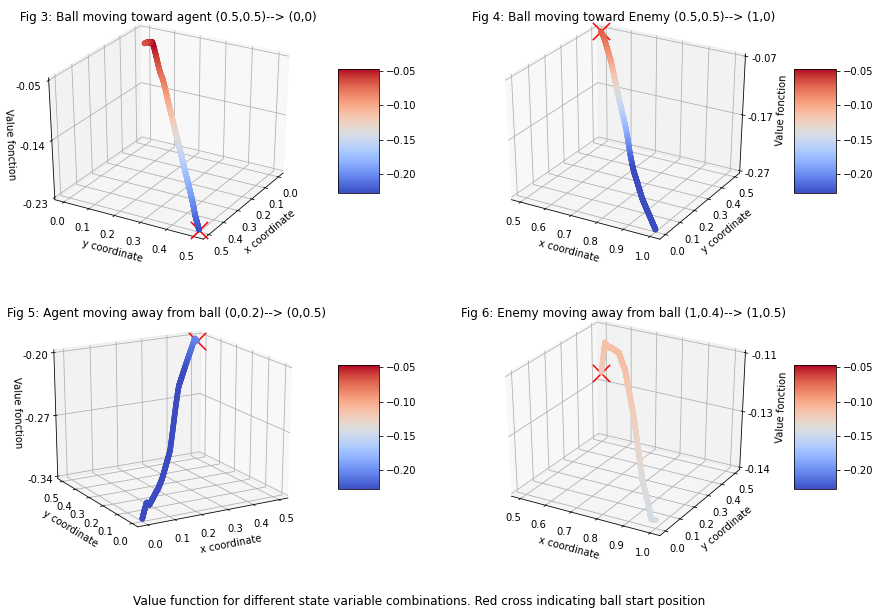

In [116]:
means[:,3], means[:,4] = np.linspace(0.5,0,1000), np.linspace(0.5,0,1000)
means[:,0] = np.linspace(0.2,0,1000)
means[:,1] = -0.04*np.ones((1000))
means[:,2] =  np.zeros((1000))
means[:,5] =  -0.25*np.ones((1000))
means[:,6] =  -0.25*np.ones((1000))

#===============
#  First subplot
#===============

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(2, 2, 1, projection='3d')

Z = model.predict(means)
vmin = Z.min()
vmax = Z.max()
plot_3d (ax,means[:,3],means[:,4],Z,vmin,vmax)

ax.set_title(' Fig 3: Ball moving toward agent (0.5,0.5)--> (0,0)')
#plot_3d(0.5,0.5,0)
ax.scatter(means[:,3][0],means[:,4][0],model.predict(means)[0],color='r',marker='x',s=300) 


ax.view_init(30,30 )
#===============
# Second subplot
#===============

ax = fig.add_subplot(2, 2, 2, projection='3d')
means =np.zeros((1000,7))
means[:,3], means[:,4] = np.linspace(0.5,1,1000), np.linspace(0.5,0,1000)
means[:,0] = np.linspace(0.2,0.5,1000)
means[:,1] = 0.45*np.ones((1000))
means[:,2] = np.linspace(0.3,0,1000)
means[:,5] =  0.25*np.ones((1000))
means[:,6] =  -0.05*np.ones((1000))
# Make data.
plot_3d (ax,means[:,3],means[:,4],model.predict(means),vmin,vmax)
ax.scatter(means[:,3][0],means[:,4][0],model.predict(means)[0],color='r',marker='x',s=300) 


ax.set_title('Fig 4: Ball moving toward Enemy (0.5,0.5)--> (1,0)')## Add a color bar which maps values to colors.
#===============
# Third subplot
#===============

means =np.zeros((1000,7))
means[:,3], means[:,4] = np.linspace(0.5,0,1000), np.linspace(0.5,0,1000)
means[:,0] = np.linspace(0.2,0.5,1000)
means[:,1] = 0.15*np.ones((1000))
means[:,2] =  np.zeros((1000))
means[:,5] =  -0.35*np.ones((1000))
means[:,6] =  -0.05*np.ones((1000))
ax = fig.add_subplot(2, 2, 3, projection='3d')
plot_3d (ax,means[:,3],means[:,4],model.predict(means),vmin,vmax)
ax.set_title('Fig 5: Agent moving away from ball (0,0.2)--> (0,0.5)')
ax.scatter(means[:,3][0],means[:,4][0],model.predict(means)[0],color='r',marker='x',s=300) 



## Add a color bar which maps values to colors.
ax.view_init(20,240)

#===============
# Fourth subplot
#===============

means =np.zeros((1000,7))
means[:,3], means[:,4] = np.linspace(0.5,1,1000), np.linspace(0.5,0,1000)
means[:,0] = np.linspace(0.2,0.5,1000)
means[:,1] = 0.45*np.ones((1000))
means[:,2] = np.linspace(0.4,0.5,1000)
means[:,5] =  0.10*np.ones((1000))
means[:,6] =  -0.25*np.ones((1000))
ax = fig.add_subplot(2, 2, 4, projection='3d')
plot_3d (ax,means[:,3],means[:,4],model.predict(means),vmin,vmax)
ax.scatter(means[:,3][0],means[:,4][0],model.predict(means)[0],color='r',marker='x',s=300) 


ax.set_title('Fig 6: Enemy moving away from ball (1,0.4)--> (1,0.5)')
ax.view_init(30,300)
fig.text(.5, .05, 'Value function for different state variable combinations. Red cross indicating ball start position', ha='center',fontsize=12)

plt.show()

  As shown in Fig 3 of the subplots, there's an increase in the value function as the agent is going from (0.5,0.5) to (0,0), which is the ball's expected position. This result make sense with this case. 

In Fig 5, There's a decrease in the value function as the agent is going away (from 0.2 to 0.5) from the ball expected position (0,0). This result makes sense because this is leads to losing a point, which is a bad choice.

  Some regions of the state space corresponds to cases that are not typical gaming cases. Thus, the agent isn't trained for those cases and make little intuitive prediction. 
Another strange behavior :  In Fig 6, the agent is put in a situation where he is sure to score a point. But the value function gives values that are slighlty less than the ones got when the agent defends his goal. 